# Phase 1 — Data Consolidation and Label Engineering

This notebook loads all CICIDS2017 CSV files, consolidates them, documents missing values, performs label encoding and saves the consolidated dataset and encoder.

Found files: 8
Loading ..\data\raw\CICIDS2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Monday-WorkingHours.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Tuesday-WorkingHours.pcap_ISCX.csv
Loading ..\data\raw\CICIDS2017\Wednesday-workingHours.pcap_ISCX.csv
Combined shape: (2830743, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Columns with missing values:
 Flow Bytes/s    1358
dtype: int64
Dropped 2867 rows due to invalid/missing values
Dropping columns: []
Label mapping (sample):


{'BENIGN': np.int64(0),
 'Bot': np.int64(1),
 'DDoS': np.int64(2),
 'DoS GoldenEye': np.int64(3),
 'DoS Hulk': np.int64(4),
 'DoS Slowhttptest': np.int64(5),
 'DoS slowloris': np.int64(6),
 'FTP-Patator': np.int64(7),
 'Heartbleed': np.int64(8),
 'Infiltration': np.int64(9),
 'PortScan': np.int64(10),
 'SSH-Patator': np.int64(11),
 'Web Attack � Brute Force': np.int64(12),
 'Web Attack � Sql Injection': np.int64(13),
 'Web Attack � XSS': np.int64(14)}

Saved consolidated dataset to ..\data\processed\CICIDS2017\combined.csv
Saved encoder to ../trained_models/encoder.pkl


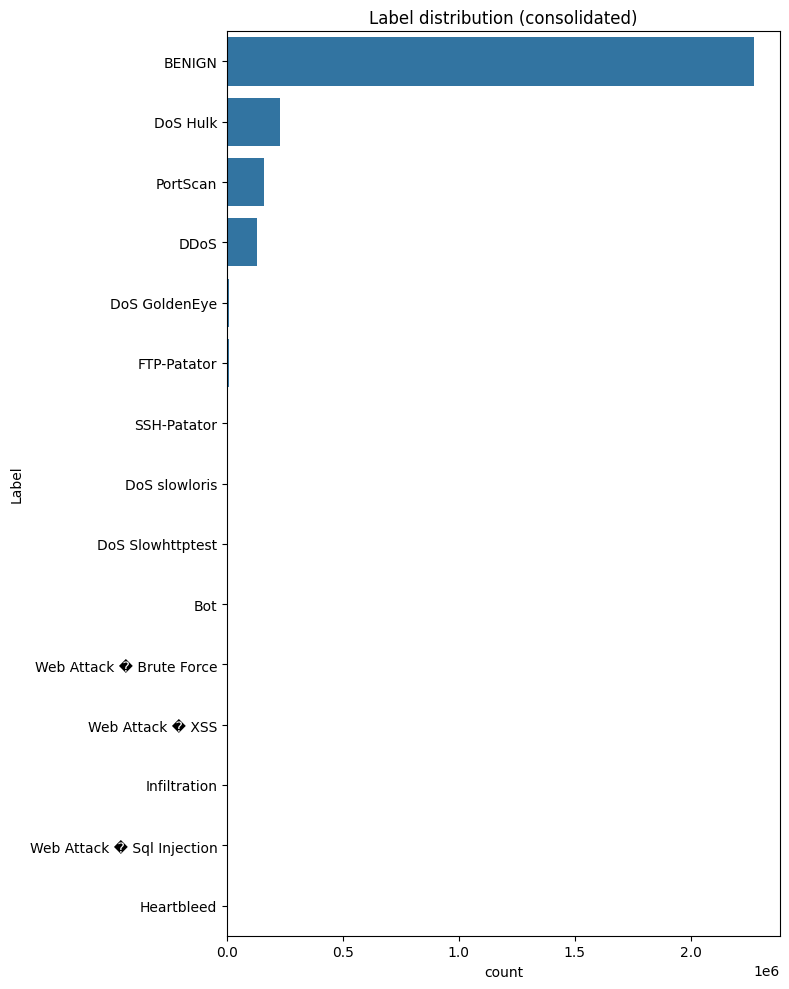

In [ ]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("../data/raw/CICIDS2017")  # change if necessary
OUT_DIR = Path("../data/processed/CICIDS2017")
OUT_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(glob.glob(str(DATA_DIR / "*.csv")))
print("Found files:", len(files))
dfs = []
for f in files:
    print("Loading", f)
    df = pd.read_csv(f, low_memory=False)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", df.shape)
display(df.head())

# Inspect missing values
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)

# Replace inf and drop rows with NaNs (document how many removed)
before = df.shape[0]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
after = df.shape[0]
print(f"Dropped {before - after} rows due to invalid/missing values")

# Drop non-informative identifiers if present
drop_cols = [c for c in ['Flow ID','Source IP','Destination IP','Timestamp','Unnamed: 0'] if c in df.columns]
print("Dropping columns:", drop_cols)
df.drop(columns=drop_cols, inplace=True, errors='ignore')

df.columns = df.columns.str.strip()

# Label encoding and saving encoder
if 'Label' not in df.columns:
    raise KeyError("Expected a 'Label' column in CICIDS files.")
encoder = LabelEncoder()

df['Label_ID'] = encoder.fit_transform(df['Label'])
print("Label mapping (sample):")
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
display(mapping)

# Save consolidated CSV and encoder
combined_path = OUT_DIR / "combined.csv"
df.to_csv(combined_path, index=False)
joblib.dump(encoder, Path('../trained_models/encoder.pkl'))
print("Saved consolidated dataset to", combined_path)
print("Saved encoder to ../trained_models/encoder.pkl")

# Plot label distribution
plt.figure(figsize=(8,10))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title("Label distribution (consolidated)")
plt.tight_layout()
